# Plotting Trajectories
Author: Talia Borofsky  
Date:   Started 2/25/21  
Project: Static environments with limited resources select for multiple foraging strategies rather than conformity  
Description:
- This code plots trajectories for interesting paramater combinations. We first plot $u_1, u_2, r_1, r_2$ trajectories for a population entirely made up of the resident phenogenotype $AB$. Then we show trajectories of $p_1, p_2, r_1, r_2, x, u$ when allele $a$ invades and $p_1, p_2, r_1, r_2, y,u$ when $b$ invades.
- Data structures used are numpy arrays, tuples, lists, and dataframes loaded from csv files in the folder. 
- In particular, note that we use the program ternary to plot ternary plots

In [2]:
import numpy as np
#import importlib
from numpy import linalg
import helperfuns
from helperfuns import *
import DatFrameFuns
from DatFrameFuns import *
import scipy.stats as scs
import matplotlib as mpl
import matplotlib.pyplot as plt
#importlib.reload(helperfuns)
import pandas as pd
#import sympy as sp
#from sympy import *
#from sympy.solvers import solve
#np.set_printoptions(precision=3, suppress = True)
#import seaborn as sns
# next two libraries are used to flatten list of lists
import functools
import operator

# for ternary plots
import ternary


# for formatting tick labels
#from matplotlib.ticker import FormatStrFormatter

#for parallelizing:
import multiprocessing as mp
from pathos.multiprocessing import ProcessingPool as Pool

## Internal Stability

### Functions

In [3]:
# functio make_internal_traj_plots
# Summary: 
#       Plots the trajectories of u1, u2, bu, r1, and r2 when u = 1, 
#       i.e. all individuals are resident type AB
# Parameters
#       init_pts: a dataframe that is a subset of the dataframe from data.csv that shows initial points,
#                 mode parameters, and final equilibrium. Parameters are the same for each initial point
#       colors: The colors corresponding to each row of the init_pts dataframe.
# Returns:
#       returns the axes and figure handles for the ternary plot and the cartesian plot
#       Also returns a dataframe of the trajectories
# Description:
#       u1,u2,bu are plotted in a ternary plot. 
#       r1 and r2 are plotted on a cartesian plot

def make_internal_traj_plots(init_pts, colors):
    # format axes and figures
    fig_u, tax = format_my_ternary() # initiates a ternary plot and formats axes
    fig_r, ax_r = format_cartesian_plot() # initiates cartesian plot and formats axes
    init_pts['color'] = colors # put in column for color
    
    # for each initial point, we find the trajectory and plot it
    # we want to record these trajectories. I'll make a dataframe of points for each trajectory, 
    # and then stack these dataframes into one master frame
    
    nrow = len(init_pts)
    row_list = np.array_split(init_pts,nrow)
    
    traj_df_list = [get_trajectory(row) for row in row_list]
    
    
    plot_my_traj_p(traj_df_list,fig_u,tax, init_pts)
    plot_my_traj_r(traj_df_list,init_pts,fig_r,ax_r)
    
    
    trajectories_df = pd.concat(traj_df_list) # makes a dataframe of all the trajectories
    # colnames = ["u1","u2","bu","r1","r2","timestep","color"]
    # trajectories_df = pd.DataFrame(trajectories_mat,columns = colnames)
    
    trajectories_df = pd.merge(left=trajectories_df, right=init_pts, 
                               on = 'color').sort_values(by=['color','tstep'])

    return(tax, fig_u, ax_r, fig_r, trajectories_df, traj_df_list)

# function format_my_ternary
# Summary: Sets up a ternary plot
# Parameters: None
# Returns: Handles to the figure and ternary axis
# Description:
#   Uses package ternary to create a ternary plot
#   Gets rid of the outer box and sets tick marks and axis labels
def format_my_ternary(if_internal = 1):
    scale = 1
    fig_u, tax = ternary.figure(scale=scale)
    
    # set up bounderize and size
    fig_u.set_size_inches(8,8)
    tax.boundary()
    
    # tick preferences
    tax.ticks(axis='lbr', multiple=.2, linewidth=1, 
              offset = 0.02, tick_formats = "%.1f"), 
    
    # turn off matplotlib's outer box and ticks
    tax.get_axes().axis('off')
    tax.clear_matplotlib_ticks()
    
    
    # Label corners - removed this for now
    if if_internal:
        rcl = r'$u_1$'
        tcl = r'$u_2$'
        lcl = r'$\bar{u}$'
    else:
        rcl = r'$p_1$'
        tcl = r'$p_2$'
        lcl = r'$\bar{p}$'
    fontsize = 20
    tax.right_corner_label(rcl, fontsize=fontsize, offset = 0.2)
    tax.top_corner_label(tcl, fontsize=fontsize, offset = 0.2)
    tax.left_corner_label(lcl, fontsize=fontsize, offset = 0.2)

    # Label sides
    #tax.left_axis_label(r'$\bar{u}$', fontsize = fontsize, offset=0.14)
    #tax.right_axis_label(r'$u_2$', fontsize = fontsize, offset=0.14)
    #tax.bottom_axis_label(r'$u_1$', fontsize = fontsize, offset=0.14)
    return(fig_u,tax)

def format_cartesian_plot(if_r = 1, zlabel = ""):
    
    fig, ax = plt.subplots(1,1,figsize = (6,6))
    if if_r:
        ax.set_xlabel(r'$r_1$', fontsize = 20)
        ax.set_ylabel(r'$r_2$', fontsize = 20)
    else:
        ax.set_xlabel(r'$u$', fontsize = 20)
        ax.set_ylabel(zlabel, fontsize = 20)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    
    #ax.legend(loc = 'best', fontsize = 14)
        #TO-DO// FILL IN


    return(fig,ax)

def get_trajectory(row):
    
    # assigning columns to variables for more readability
    K,pc,D,beta, u1, u2, bu, r1, r2 = np.transpose(*row[['K','pc','D','beta', 'u1init','u2init',
                                                       'buinit', 'r1init','r2init']].values)
    uvec = np.array([u1,u2,bu]); rvec = np.array([r1,r2])
    xvec = np.array([0,0,0])
    yvec = np.array([0,0,0])
    list_rows = []
    
    eq_pt = np.transpose(row[['u1eq','u2eq','bueq','r1eq','r2eq']].values)
    for t in range(0,200):
        curr_row = pd.DataFrame({"u1":uvec[0], "u2": uvec[1], "bu": uvec[2],
                                 "r1":rvec[0], "r2": rvec[1],
                                 "tstep":t, "color":row.color})
        list_rows.append(curr_row)
        
        curr_pt = np.transpose(*curr_row[['u1','u2','bu','r1','r2']].values)
        if np.allclose(curr_pt, eq_pt,rtol = 1e-6, atol = 1e-6):
            break
        else:
            uvec,xvec,yvec,rvec,W = NextGen(uvec,xvec,yvec,rvec,D,K,pc,beta)
    
    traj_df =  pd.concat(list_rows) 
    return(traj_df.sort_values(by=['tstep']))
        
    
def plot_my_traj_p(traj_df_list, fig_u, tax,init_pts = [], if_internal = 1):
    
    for i in range(0,4):
        traj_df = traj_df_list[i]
        traj_df = traj_df.sort_values(by="tstep")
        umat = traj_df[['u1','u2','bu']].values
        if if_internal==0:
            xmat = traj_df[['x1','x2','bx']].values
            ymat = traj_df[['y1','y2','by']].values
            pmat = umat + xmat + ymat
        else:
            pmat = umat
                
        trajectory = list(map(tuple,pmat))
    #color = traj_df.color[0]               
        label = "Starting with IP %d"%(i+1) if if_internal else "Perturbation %d"%(i+1)
        tax.plot(trajectory, color = traj_df.color.values[0], label = label)
    
    if if_internal:
        # plot initial points as black squares
        init_u_pts = list(map(tuple, init_pts[['u1init','u2init','buinit']].values ))
        tax.scatter(init_u_pts, marker='s', color='k', label="Initial Points")
        equilibria = pd.unique(list(map(tuple, init_pts[['u1eq','u2eq','bueq']].values )))

        # plot equilibrium (or equilibria) as a black star
        eqlabel = 'equilibrium' if len(equilibria) == 1 else 'equilibria'
        tax.scatter(equilibria, marker = '*', color = 'k', label = eqlabel, s = 200)
    tax.legend(loc="best", fontsize=14)
    tax.resize_drawing_canvas(scale=1.05)
    

    return(1)
"""
Iterates from an initial point until the iteration approximately reaches equilibrium

Parameters
----
row 
    - a row from the init_pts dataframe.

Returns
----
    traj_df -  a dataframe with the values of u1, u2, bu, r1, r2 
        for each time step until they reach the equilibrium
"""
def plot_my_traj_r(traj_df_list,init_pts,fig_r,ax_r, if_internal = 1):
    for i in range(0,4):
        traj_df = traj_df_list[i]
        traj_df = traj_df.sort_values(by="tstep") # sorting just in case
        r1vec = traj_df.r1
        r2vec = traj_df.r2
        if if_internal:
            ax_r.plot(r1vec, r2vec, color = traj_df.color.values[0], label = "Starting with IP %d"%(i+1))
        else:
            ax_r.plot(r1vec, r2vec, color = traj_df.color.values[0], label = "Perturbation %d"%(i+1))
    
    # plot initial points as black squares
    if if_internal:
        r1init = init_pts.r1init.values
        r2init = init_pts.r2init.values
        ax_r.scatter(r1init, r2init, marker='s', color='k', label="Initial Points")
    
        # plot equilibrium(a)
        equilibria = pd.unique(list(map(tuple, init_pts[['r1eq','r2eq']].values ))) # pd.unique needs a list of tuples
        r1eq_vec = [point[0] for point in equilibria]
        r2eq_vec = [point[1] for point in equilibria]
        eqlabel = 'equilibrium' if len(equilibria) == 1 else 'equilibria'
        ax_r.scatter(r1eq_vec, r2eq_vec, marker = '*', color = 'k', label = eqlabel, s = 200)
   
    #ax_r.legend(loc = "best", fontsize=14)
    return(1)


In [58]:
"""
make_external_traj_plots (row, colors)

Plots the trajectories after perturbing in the x or y direction. Plots:
    (1) a ternary plot of p1, p2, bp, 
    (2) a cartesian plot of r1, r2
    (3) a cartesian plot of u - z (z is a stand-in for x or y)
---
Parameters
    row: a row from the UniqueEquilibria dataframe
    ds: change in s. If not introducing allele a, then ds = 0
    dD: change in D. If not introducing allele b, then dD = 0.
---
Returns:
    tax_p, fig_p = axis and figure for ternary plot of p1, p2, bp
    ax_r, fig_r = axis and figure of plot of r1-r2
    ax_uz, fig_uz = axis and figure of plot of u - z
    trajectories_df: dataframe of u1,u2,bu,r1,r2,z1,z2,bz values for each time point, labeled by which perturbation
"""
def make_external_traj_plots(row, ds, dD, colors):
    # format axes and figures
    fig_p, tax_p = format_my_ternary(if_internal = 0) # initiates a ternary plot and formats axes
    fig_r, ax_r = format_cartesian_plot(if_r = 1) # initiates cartesian plot and formats axes
    zlabel = r'$x$' if ds!= 0 else r'$y$'
    fig_uz, ax_uz = format_cartesian_plot(if_r = 0, zlabel = zlabel) 
    
    
    perturb_list = Perturb(row)
    
    traj_df_list = [get_trajectory_external(row, perturbation, color, ds, dD) for perturbation, 
                    color in zip(perturb_list, colors)]
    
    plot_my_traj_p(traj_df_list, fig_p, tax_p, if_internal = 0)
    plot_my_traj_r(traj_df_list,row,fig_r,ax_r, if_internal = 0)
    
    plot_my_traj_uz(traj_df_list,row, fig_uz, ax_uz)
    trajectories_df = []
    trajectories_df = pd.concat(traj_df_list) # makes a dataframe of all the trajectories    
    trajectories_df = trajectories_df.sort_values(by=['color','tstep'])

    return(tax_p, fig_p, ax_r, fig_r, ax_uz, fig_uz, trajectories_df)
"""
Perturb

Finds valid perturbations for a set of equilibria (i.e. perturbations that won't result in invalid frequencies)
---
Parameters
    row
---
Returns
    list of perturbations in the u -direction, the z direction (stand-in for x or y... i know it's confusing),
and the r direction
"""
def Perturb(row):
    u1eq, u2eq, bueq, r1eq, r2eq = np.transpose(*row[['u1eq','u2eq','bueq', 'r1eq','r2eq']].values)
    # use dyvec here but dxvec could work too
    uvec = [u1eq, u2eq, bueq]
    rvec = [r1eq, r2eq]
    # get new post-perturb vectors
    du = 0.01
    change_u_1 = -du*np.array([0.015, 0.11, 1 - 0.015 - 0.11])
    change_u_2 = -du*np.array([0.29, 0.49, 1 - 0.29 - 0.49])
    change_u_3 = -du*np.array([0.49, 0.51, 1 - 0.51 - 0.49])
    change_u_4 = -du*np.array([0.9,0.05, 0.05])
    change_u_list = [Perturb_EdgeCase(uvec,duvec) for duvec in [change_u_1, change_u_2,
                                                                change_u_3, change_u_4]]
    change_u_1, change_u_2, change_u_3, change_u_4 = change_u_list
    
    dz = 0.01
    new_z_1 = dz*np.array([0.05,0.1, 1 - 0.05 - 0.1])
    new_z_2 = dz*np.array([0.48, 0.5, 1 - 0.48 - 0.5])
    new_z_3 = dz*np.array([0.9, 0.04, 0.06])
    new_z_4 = dz*np.array([0.3,0.6,1 - 0.9])
    
    dr = 0.01
    change_r_1 = dr*np.array([1,0.9])
    change_r_2 = dr*np.array([0.5,-0.3])
    change_r_3 = dr*np.array([-1,0.99])
    change_r_4 = dr*np.array([-0.2, -0.8])
    change_r_list = [Perturb_EdgeCase_r(rvec, drvec) for drvec in [change_r_1,change_r_2,
                                                                 change_r_3, change_r_4]]
    [change_r_1, change_r_2, change_r_3, change_r_4] = change_r_list
    
    return([change_u_1, new_z_1, change_r_1], [change_u_2, new_z_2, change_r_2],
          [change_u_3, new_z_3, change_r_3], [change_u_4, new_z_4, change_r_4])
    
    # now get new post-perturbation vectors
        
    
"""
Perturb_EdgeCase

    Adjusts the direction of a perturbation to account for cases where u_1 = 0, u_2 = 0, or bu = 0
    ---
    Parameters
        uvec - 3-vector (np.array) of the equilibrium u1, u2, bu values
        duvec - 3-vector (np.array) of delta_(u_1), delta_(u_2), delta_(ubar)
    ---
    Returns
        duvec - the original duvec adjusted so we do not perturb u1, u2, bu over a boundary
"""
def Perturb_EdgeCase(uvec,duvec):
    #recursively checks for edge cases so i don't get an invalid frequency. Adjusts duvec if needed
    
    # make sure using numpy arrays
    du = sum(duvec)
    uvec = np.array(uvec); duvec = np.array(duvec);
    # find locations of edge cases
    edge_bool = uvec + duvec <= 0
    
    n = sum(edge_bool)
    if n>0:
        duvec[edge_bool] = -uvec[edge_bool] +0.00001 # so not at exactly 0
        du_remain = du - sum(duvec)
        duvec[~edge_bool] = duvec[~edge_bool] + (1/np.float64(3-n))*du_remain
        
        # make sure that we didn't cause a different frequency to be negative:
        return(Perturb_EdgeCase(uvec,duvec))

    else:
        return(duvec)
"""
Perturb_EdgeCase

    Adjusts the direction of a perturbation to account for cases where r_i = 0 or 1
    ---
    Parameters
        rvec - 2-vector of the equilibrium r1, r2 values
        drvec - 2-vector of delta_(r_1), delta_(r_2)
    ---
    Returns
        drvec - the original drvec adjusted so we do not perturb r1, r2 over a boundary
"""
def Perturb_EdgeCase_r(rvec,drvec):
    #recursively checks for edge cases so i don't get an invalid frequency. Adjusts duvec if needed
    
    # make sure using numpy arrays
    rvec = np.array(rvec); drvec = np.array(drvec);
    # find locations of edge cases
    edge_bool_0 = rvec + drvec <= 0 
    edge_bool_1 = rvec + drvec >= 1
    edge_bool = edge_bool_0 + edge_bool_1
    drvec[edge_bool] = -drvec[edge_bool] # just change the direction of the perturbation
    return(drvec)
    


"""
get_trajectory

Perturbs the (former) equilibrium in a given direction and records the trajectory
---
Parameters
    row
    direction - a list of (np.array) vectors: 
        - a 3-vector of change i u_1, u_2, and bar u values
        - a 3-vector of x values and a 3-vector of y-values
        - a 2 vector of change in r_1, r_2 values
    ds
        delta_s value of allele $a$. set to 0 if not introducing $a$
    dD
        delta_D value of allele $b$. set to 0 if not introducing $b$
---
Returns
    traj_df, a dataframe with 
        - u1,u2,bu,r1,r2,x1,x2,bx,y1,y2,by values
        - W values
        - columns for time step, 
        - delta_s value (same for each row), delta_D value (same for each row), and color (same for each row)

"""
def get_trajectory_external(row, perturbation, color, ds, dD):
    
    # assigning columns to variables for more readability
    s,mu,K,pc,D,beta,W, u1, u2, bu, r1, r2 = np.transpose(*row[['s','mu','K','pc','D','beta','Weq', 'u1eq','u2eq',
                                                       'bueq', 'r1eq','r2eq']].values)
    [duvec, dzvec, drvec] = perturbation
    uvec = np.array([u1,u2,bu]) + duvec; 
    xvec = dzvec if ds !=0 else np.array([0,0,0]); 
    yvec = dzvec if dD != 0 else np.array([0,0,0])
    rvec = np.array([r1,r2]) + drvec
    
    # calculate dk and d_(pi_C)
    norm = scs.norm(mu,1)
    dk = Kfun(s + ds, norm) - K
    dpc = pcfun(s + ds, norm) - pc
    
    list_rows = []
    for t in range(0,200000):
        curr_row = pd.DataFrame({"u1":uvec[0], "u2": uvec[1], "bu": uvec[2], 
                                 "x1":xvec[0], "x2": xvec[1], "bx": xvec[2],
                                 "y1":yvec[0], "y2": yvec[1], "by": yvec[2],
                                 "r1":rvec[0], "r2": rvec[1], "W": W,
                                 "tstep":t, "color":color, "ds":ds, "dD":dD},
                                index=[t])
        list_rows.append(curr_row)
        curr_pt = np.transpose(*curr_row[['u1','u2','bu','x1','x2','bx','y1','y2','by','r1','r2']].values)
        if t>1:
            if np.allclose(curr_pt, old_pt,rtol = 1e-10, atol = 1e-10):
                break
        uvec,xvec,yvec,rvec,W = NextGen(uvec,xvec,yvec,rvec,D,K,pc,beta, [dD, dk, dpc])
        old_pt =  curr_pt
            
    
    traj_df =  pd.concat(list_rows) 
    return(traj_df.sort_values(by=['tstep']))


def plot_my_traj_uz(traj_df_list,row, fig_uz, ax_uz):
    for i in range(0,4):
        traj_df = traj_df_list[i]
        traj_df = traj_df.sort_values(by="tstep") # sorting just in case
        u = traj_df.u1 + traj_df.u2 + traj_df.bu
        x = traj_df.x1 + traj_df.x2 + traj_df.bx
        ax_uz.plot(u.values, x.values, color = traj_df.color.values[0], label = "Perturbation %d"%(i+1))
    
    # plot initial points as black squares
    
   
    #ax_r.legend(loc = "best", fontsize=14)
    return(1)

### Load DataFrames

In [6]:
df_UniqueEquilibria = pd.read_csv('UniqueEquilibriaDF_fixed.csv')
df_InitialPoints = pd.read_csv('data.csv')



### Choose paramater combo to look at and initial points
Store the equilibria. We will use this for stopping the trajectory function

I'll choose a value where there is moderate food depletion ($\beta = 0.5$) and poor information ($\mu = -0.5$)

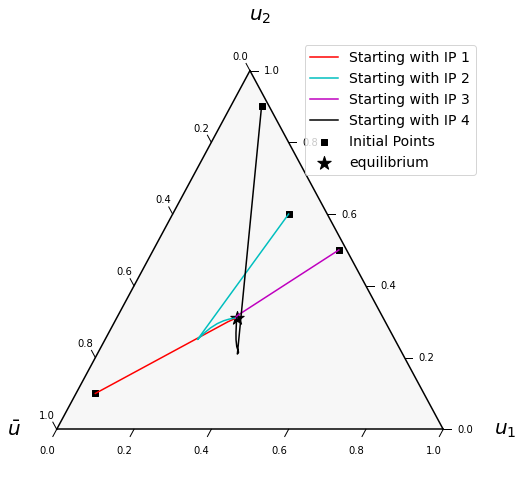

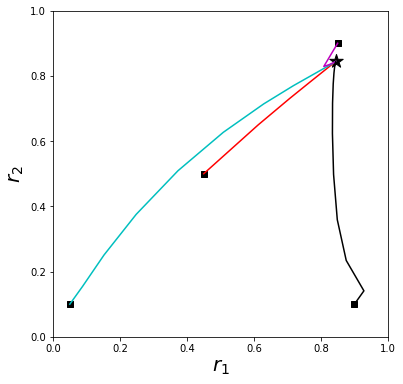

In [10]:
# choose equilibria where 
row_init_eq = df_UniqueEquilibria.query('K==0 & beta == 0.5 & D==0 & mu==-0.5')
init_pts_all = df_InitialPoints.query('K==0 & beta == 0.5 & D==0 & mu == -0.5')


colors = ['r','c','m','k']
# choose initial points
row1 = init_pts_all.query('u1init==0.05 &  u2init == 0.1 & r1init == 0.45 & r2init ==0.5')
row2 = init_pts_all.query('u1init==0.3 &  u2init == 0.6 & r1init == 0.05 &  r2init ==0.1 ')
row3 = init_pts_all.query('u1init==0.48 &  u2init == 0.5 & r1init == 0.85 & r2init ==0.9')
row4 = init_pts_all.query('u1init==0.08 &  u2init == 0.9 & r1init == 0.9 &  r2init ==0.1 ')
init_pts = pd.concat([row1,row2,row3,row4])

# plot trajectories for each initial point
tax, fig_u, ax_r, fig_r, trajectories_df, traj_df_list = make_internal_traj_plots(init_pts, colors)

fig_u.savefig("TrajectoryPlots/u_intern_K_0_D_0_beta_0_5_mu_neg0_5", bbox_inches='tight')
fig_r.savefig("TrajectoryPlots/r_intern_K_0_D_0_beta_0_5_mu_neg0_5", bbox_inches='tight')

In [13]:
row_init_eq.C_D

212   -0.0
Name: C_D, dtype: float64

# Try another one for which social learning can invade

In [54]:
row_init_eq = df_UniqueEquilibria.query('D==0 & mu == -1.0 & s == 2 & beta==0.5') 
init_pts_all = df_InitialPoints.query('D==0 & mu == -1.0 & s == 2 & beta == 0.5')
colors = ['r','c','m','k']
# choose initial points
row1 = init_pts_all.query('u1init==0.05 &  u2init == 0.1 & r1init == 0.45 & r2init ==0.5')
row2 = init_pts_all.query('u1init==0.3 &  u2init == 0.6 & r1init == 0.05 &  r2init ==0.1 ')
row3 = init_pts_all.query('u1init==0.48 &  u2init == 0.5 & r1init == 0.85 & r2init ==0.9')
row4 = init_pts_all.query('u1init==0.08 &  u2init == 0.9 & r1init == 0.9 &  r2init ==0.1 ')

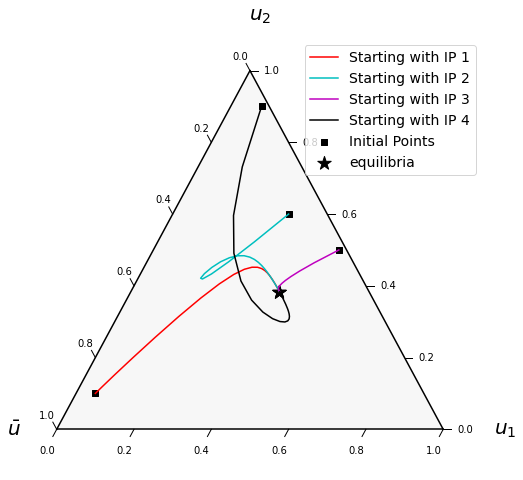

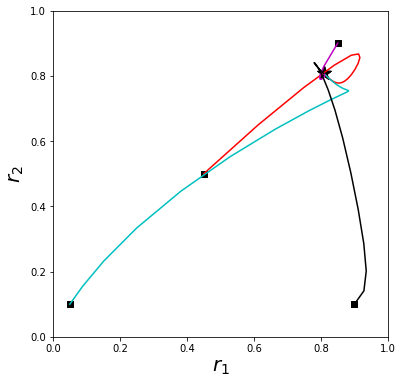

In [56]:
# choose equilibria where 

init_pts = pd.concat([row1,row2,row3,row4])

# plot trajectories for each initial point
tax, fig_u, ax_r, fig_r, trajectories_df, traj_df_list = make_internal_traj_plots(init_pts, colors)

#fig_u.savefig("TrajectoryPlots/u_intern_K_0_D_0_beta_0_5_mu_neg0_5", bbox_inches='tight')
#fig_r.savefig("TrajectoryPlots/r_intern_K_0_D_0_beta_0_5_mu_neg0_5", bbox_inches='tight')

# Introducing alleles $a$ or $b$, with $\delta_{s} < 0$ or $\delta_{s} > 0$, and $\delta_{D} < 0$ or $\delta_{D} > 0$, respectively.

We will investigate invasion of both $a$ or $b$ respectively.
- For $K = D = 0$, allele $a$ will have $\delta_s > 0$ and allele $b$ will have $\delta_D > 0$.

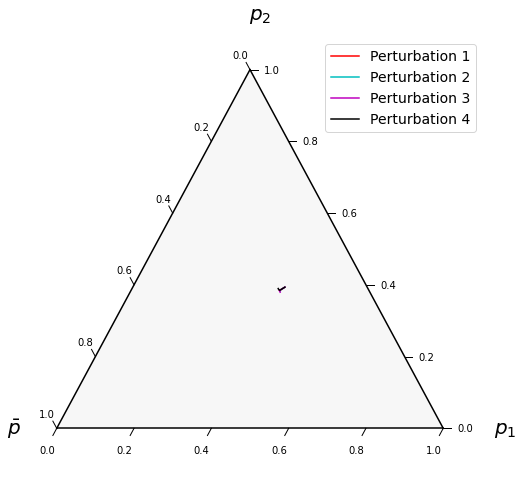

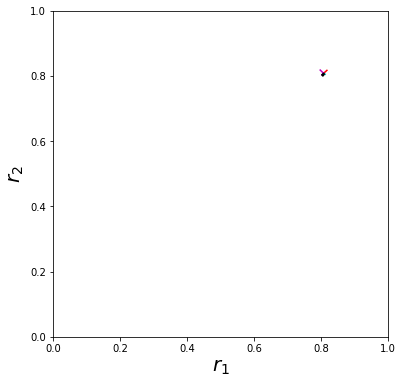

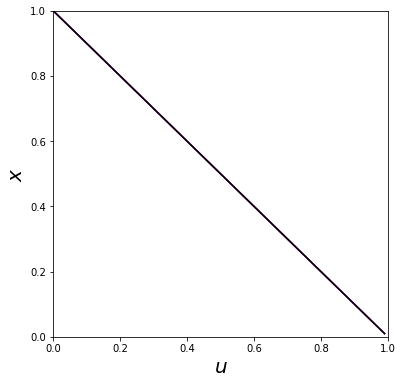

In [61]:
colors = ['r','c','m','k']
ds =  0.05
dD = 0.0
tax_p, fig_p, ax_r, fig_r, ax_uz, fig_uz, trajectories_df = make_external_traj_plots(row_init_eq, ds, dD, colors)

In [ ]:
colors = ['r','c','m','k']
ds = -0.01
dD = 0.0
tax_p, fig_p, ax_r, fig_r, ax_uz, fig_uz, trajectories_df = make_external_traj_plots(row_init_eq, ds, dD, colors)

In [84]:
trajectories_df['x'] = trajectories_df[['x1','x2','bx']].sum(axis=1)
trajectories_df.query('tstep < 3')

,u1,u2,bu,x1,x2,bx,y1,y2,by,r1,r2,W,tstep,color,ds,dD,x
0,0.296539,0.286539,0.366922,0.024000,0.025000,0.001000,0.0,0.0,0.0,0.849480,0.841480,1.829645,0,c,0.001,0.0,0.050000
1,0.296193,0.294912,0.358910,0.015583,0.015515,0.018887,0.0,0.0,0.0,0.845002,0.842737,1.830235,1,c,0.001,0.0,0.049985
2,0.295641,0.295278,0.359110,0.015549,0.015529,0.018892,0.0,0.0,0.0,0.844594,0.843674,1.829241,2,c,0.001,0.0,0.049970
0,0.266039,0.308539,0.375422,0.015000,0.030000,0.005000,0.0,0.0,0.0,0.842480,0.836480,1.829645,0,k,0.001,0.0,0.050000
1,0.295670,0.294707,0.359637,0.015554,0.015505,0.018926,0.0,0.0,0.0,0.850254,0.833861,1.826532,1,k,0.001,0.0,0.049985
2,0.296664,0.294036,0.359330,0.015602,0.015464,0.018904,0.0,0.0,0.0,0.847558,0.838878,1.828123,2,k,0.001,0.0,0.049970
0,0.286539,0.285539,0.377922,0.045000,0.002000,0.003000,0.0,0.0,0.0,0.834480,0.854380,1.829645,0,m,0.001,0.0,0.050000
1,0.293895,0.297083,0.359037,0.015462,0.015628,0.018894,0.0,0.0,0.0,0.834367,0.855233,1.829586,1,m,0.001,0.0,0.049985
2,0.293845,0.297187,0.358998,0.015454,0.015630,0.018886,0.0,0.0,0.0,0.839349,0.849891,1.829815,2,m,0.001,0.0,0.049970
0,0.310289,0.305539,0.334172,0.002500,0.005000,0.042500,0.0,0.0,0.0,0.854480,0.853480,1.829645,0,r,0.001,0.0,0.050000


In [43]:
sum(trajectories_df[['x1', 'x2','bx']].iloc[-1,:])

8.375370561971285e-08

In [9]:
fig_p.savefig("TrajectoryPlots/p_extern_increase_social_K_0_D_0_beta_0_5_mu_neg0_5", bbox_inches='tight')
fig_r.savefig("TrajectoryPlots/r_extern_increase_social_K_0_D_0_beta_0_5_mu_neg0_5", bbox_inches='tight')
fig_uz.savefig("TrajectoryPlots/ux_extern_increase_social_K_0_D_0_beta_0_5_mu_neg0_5", bbox_inches='tight')

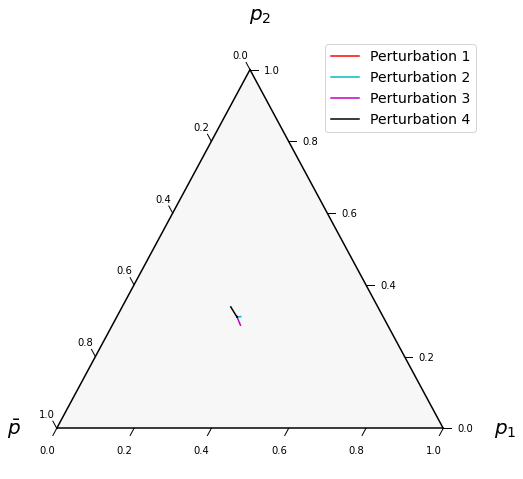

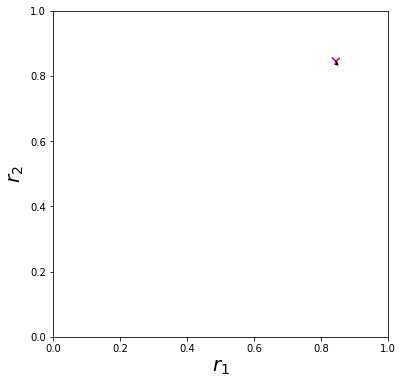

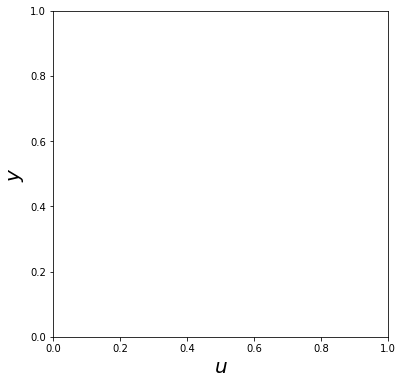

In [68]:
ds = 0.0001
dD = 0
tax_p, fig_p, ax_r, fig_r, ax_uz, fig_uz, trajectories_df = make_external_traj_plots(row_init_eq, ds, dD, colors)

In [69]:
s,mu,K,pc,D,beta,W, u1, u2, bu, r1, r2 = np.transpose(*row_init_eq[['s','mu','K','pc','D','beta','Weq', 'u1eq','u2eq',
                                                       'bueq', 'r1eq','r2eq']].values)

In [67]:
ds = 0.001
norm = scs.norm(mu,1)
dk = Kfun(s + ds, norm) - K
dpc = pcfun(s + ds, norm) - pc


In [61]:
lambda_x_remnant = (1/W)*(dpc + dk*(r1*u1 + r2*u2))

In [63]:
lambda_x_remnant + 1

1.000102047844681

In [66]:
df_UniqueEquilibria.query('C_s > 0.1 & K == 0 & D >-0.1')

,Unnamed: 0,K,pc,s,mu,D,beta,u1eq,u2eq,bueq,...,Weq,URstable,NumInitials,C_s,C_D,difference,y_neg_invades,y_pos_invades,x_neg_invades,x_pos_invades
